In [2]:
# Setup and importing libraries 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split

# Hyperparameter Tuning with Memory Management
import keras_tuner as kt
from tensorflow.keras import backend as K
import gc
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Data is loaded and split into training, validation and test sets. 
# Datasets are converted to float32 for better compatibility with GPU/M2chips for faster training.
# Dataset is then standardised to center and scale data, with the mean and std of each channel.
# Load CIFAR-10 data
(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()

# Flatten the labels to ensure they are 1D arrays
y_train_full = y_train_full.flatten()
y_test = y_test.flatten()

# Split training data into training and validation sets with stratification
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42
)

# Convert to float32 for faster computations
X_train, X_val, X_test = X_train.astype('float32'), X_val.astype('float32'), X_test.astype('float32')

# Standardize based on CIFAR-10 dataset statistics
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]
X_train = (X_train - mean) / std
X_val = (X_val - mean) / std
X_test = (X_test - mean) / std

# Set up data augmentation for training
datagen = ImageDataGenerator(
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
)
train_gen = datagen.flow(X_train, y_train, batch_size=32)

# Print shapes for confirmation
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

# Optional: Check class distribution
unique, counts = np.unique(y_train, return_counts=True)
print("Training set class distribution:", dict(zip(unique, counts)))

Training set shape: (40000, 32, 32, 3) (40000,)
Validation set shape: (10000, 32, 32, 3) (10000,)
Test set shape: (10000, 32, 32, 3) (10000,)
Training set class distribution: {0: 4000, 1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000, 6: 4000, 7: 4000, 8: 4000, 9: 4000}


/Users/edwardquah/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-11-06 16:51:48.125211: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-11-06 16:51:48.125233: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-11-06 16:51:48.125239: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-11-06 16:51:48.125252: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-06 16:51:48.125263: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.c

Epoch 1/50


/Users/edwardquah/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-11-06 16:51:49.504142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - accuracy: 0.2864 - loss: 2.0063 - val_accuracy: 0.4857 - val_loss: 1.4649 - learning_rate: 0.0010
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - accuracy: 0.5017 - loss: 1.4013 - val_accuracy: 0.5524 - val_loss: 1.2882 - learning_rate: 0.0010
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - accuracy: 0.5910 - loss: 1.1782 - val_accuracy: 0.6500 - val_loss: 0.9824 - learning_rate: 0.0010
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - accuracy: 0.6400 - loss: 1.0413 - val_accuracy: 0.5650 - val_loss: 1.3580 - learning_rate: 0.0010
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 50ms/step - accuracy: 0.6767 - loss: 0.9553 - val_accuracy: 0.7171 - val_loss: 0.8025 - learning_rate: 0.0010
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - accuracy: 0.7114 - loss: 0.8701 - val_accuracy: 0.7242 - val_loss: 0.8166 - learning_rate: 0.0010
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 62ms/step - accuracy: 0.7172 - loss: 0.8307

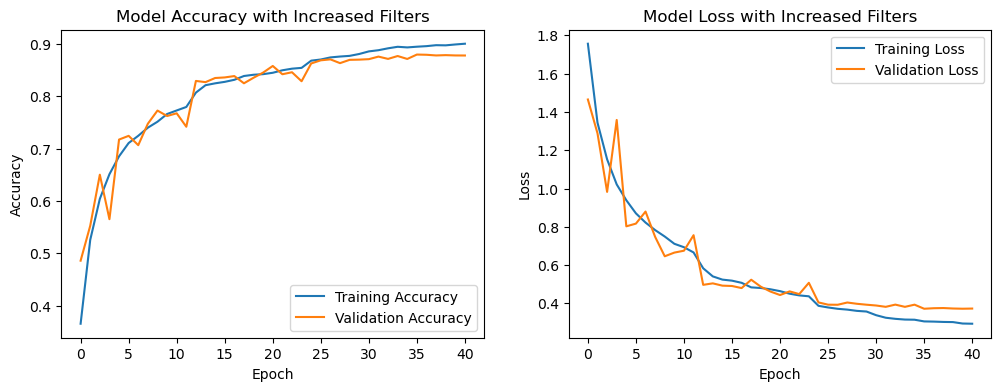

In [3]:
# Batch Norm AND Increased Filters 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define the CNN model with increased filters
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),

    Flatten(),
    Dense(512, activation='relu'),  # Increased from 256
    Dropout(0.5),
    Dense(256, activation='relu'),  # Increased from 128
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Train the model with data augmentation
history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, lr_scheduler])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy with Increased Filters: {test_accuracy}')

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy with Increased Filters')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss with Increased Filters')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [4]:
# # Display a simple summary of the model with layer names, output shapes, and parameter counts
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10, 10, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 3, 3, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 3, 3, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 1, 1, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1, 1, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,57

 Total params: 4,239,840 (16.17 MB)

 Trainable params: 1,412,682 (5.39 MB)

 Non-trainable params: 1,792 (7.00 KB)

 Optimizer params: 2,825,366 (10.78 MB)

Epoch 1/50


/Users/edwardquah/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-11-07 16:43:06.654691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


625/625 ━━━━━━━━━━━━━━━━━━━━ 98s 142ms/step - accuracy: 0.3692 - loss: 1.7537 - val_accuracy: 0.5347 - val_loss: 1.3046
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 88s 140ms/step - accuracy: 0.5441 - loss: 1.2609 - val_accuracy: 0.5760 - val_loss: 1.2068
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 88s 140ms/step - accuracy: 0.6012 - loss: 1.1087 - val_accuracy: 0.6014 - val_loss: 1.1267
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 88s 140ms/step - accuracy: 0.6488 - loss: 0.9858 - val_accuracy: 0.6621 - val_loss: 0.9487
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 96s 153ms/step - accuracy: 0.6889 - loss: 0.8815 - val_accuracy: 0.6749 - val_loss: 0.9195
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 101s 162ms/step - accuracy: 0.7100 - loss: 0.8107 - val_accuracy: 0.7054 - val_loss: 0.8487
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 108s 172ms/step - accuracy: 0.7375 - loss: 0.7407 - val_accuracy: 0.6819 - val_loss: 0.9187
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 108s 173ms/step - accuracy: 0.7546 - loss: 0.6907 - 

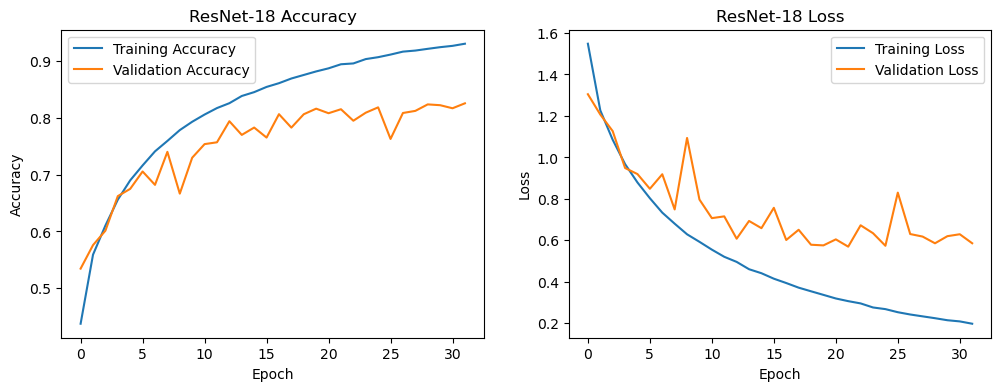

In [4]:
# Resnet-18
from tensorflow.keras.layers import Input, Add, Conv2D, BatchNormalization, ReLU, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Define the ResNet block (Basic Block)
def resnet_block(x, filters, strides=(1, 1)):
    # Save input for the shortcut connection
    x_skip = x

    # First convolutional layer in the block
    x = Conv2D(filters, (3, 3), strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second convolutional layer in the block
    x = Conv2D(filters, (3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)

    # Adjust dimensions with a convolutional layer on the shortcut path if necessary
    if strides != (1, 1) or x_skip.shape[-1] != filters:
        x_skip = Conv2D(filters, (1, 1), strides=strides, padding='same')(x_skip)
        x_skip = BatchNormalization()(x_skip)

    # Add the shortcut connection and apply ReLU activation
    x = Add()([x, x_skip])
    x = ReLU()(x)
    return x

# Define the ResNet-18 model
def build_resnet18(input_shape=(32, 32, 3), num_classes=10):
    inputs = Input(shape=input_shape)

    # Initial convolutional layer
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)

    # Residual blocks
    x = resnet_block(x, 64)
    x = resnet_block(x, 64)

    x = resnet_block(x, 128, strides=(2, 2))
    x = resnet_block(x, 128)

    x = resnet_block(x, 256, strides=(2, 2))
    x = resnet_block(x, 256)

    x = resnet_block(x, 512, strides=(2, 2))
    x = resnet_block(x, 512)

    # Global average pooling and dense layer for output
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = Model(inputs, outputs)
    return model

# Instantiate and compile the model
resnet18_model = build_resnet18()
resnet18_model.compile(optimizer=Adam(learning_rate=1e-4),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history_resnet18 = resnet18_model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

# Evaluate on the test set
test_loss_resnet18, test_accuracy_resnet18 = resnet18_model.evaluate(X_test, y_test)
print(f'ResNet-18 Test Accuracy: {test_accuracy_resnet18}')

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet18.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet18.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet-18 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_resnet18.history['loss'], label='Training Loss')
plt.plot(history_resnet18.history['val_loss'], label='Validation Loss')
plt.title('ResNet-18 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [10]:
resnet18_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 32, 32,    │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_17 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 16,    │          0 │ re_lu_17[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 16, 16,    │     36,928 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_18 (ReLU)     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 16, 16,    │     36,928 │ re_lu_18[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_19 (ReLU)     │ (None, 16, 16,    │          0 │ add_8[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 16, 16,    │     36,928 │ re_lu_19[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_20 (ReLU)     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 16, 16,    │     36,928 │ re_lu_20[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_24[0][0] 

 Total params: 33,545,888 (127.97 MB)

 Trainable params: 11,178,762 (42.64 MB)

 Non-trainable params: 9,600 (37.50 KB)

 Optimizer params: 22,357,526 (85.29 MB)

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.2297 - loss: 2.0733 - val_accuracy: 0.4790 - val_loss: 1.4579
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.4505 - loss: 1.4952 - val_accuracy: 0.5195 - val_loss: 1.3552
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.5441 - loss: 1.2692 - val_accuracy: 0.6175 - val_loss: 1.0740
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.6037 - loss: 1.1160 - val_accuracy: 0.6657 - val_loss: 0.9519
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.6481 - loss: 0.9953 - val_accuracy: 0.6965 - val_loss: 0.8537
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.6810 - loss: 0.9166 - val_accuracy: 0.7141 - val_loss: 0.8086
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 53ms/step - accuracy: 0.7128 - loss: 0.8351 - val_accuracy: 0.7260 - val_loss: 0.7970
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 55ms/step - accuracy: 0.7280 - loss: 0.7905 - 

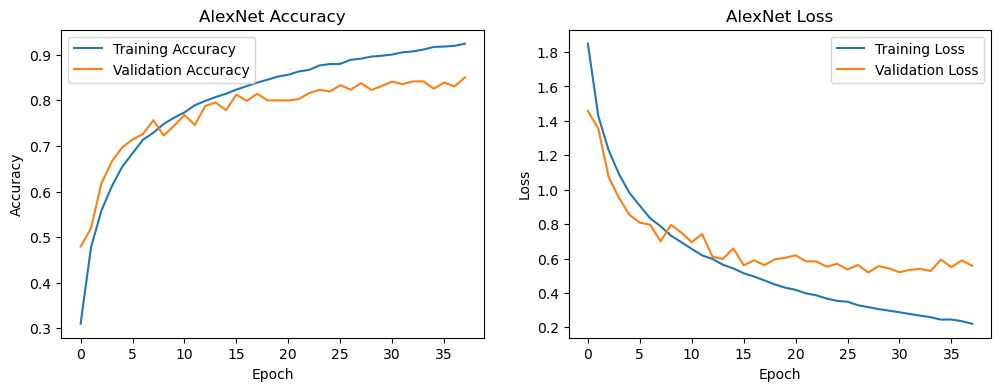

In [6]:
# AlexNet
alexnet_model = Sequential([
    Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(32, 32, 3)),
    BatchNormalization(),
    MaxPooling2D((3, 3), strides=(2, 2)),

    Conv2D(256, (5, 5), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((3, 3), strides=(2, 2)),

    Conv2D(384, (3, 3), padding='same', activation='relu'),
    Conv2D(384, (3, 3), padding='same', activation='relu'),
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((3, 3), strides=(2, 2)),

    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compile and train
alexnet_model.compile(optimizer=Adam(learning_rate=1e-4),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

history_alexnet = alexnet_model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

# Evaluate and plot
test_loss_alexnet, test_accuracy_alexnet = alexnet_model.evaluate(X_test, y_test)
print(f'AlexNet Test Accuracy: {test_accuracy_alexnet}')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_alexnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_alexnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('AlexNet Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_alexnet.history['loss'], label='Training Loss')
plt.plot(history_alexnet.history['val_loss'], label='Validation Loss')
plt.title('AlexNet Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [12]:
alexnet_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_45 (Conv2D)              │ (None, 30, 30, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 15, 15, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 15, 15, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 7, 7, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,343,712 (24.20 MB)

 Trainable params: 2,114,442 (8.07 MB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 4,228,886 (16.13 MB)

Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 130s 182ms/step - accuracy: 0.1576 - loss: 2.6170 - val_accuracy: 0.1002 - val_loss: 2.3403 - learning_rate: 0.0010
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 109s 174ms/step - accuracy: 0.2824 - loss: 1.9637 - val_accuracy: 0.2891 - val_loss: 2.1996 - learning_rate: 0.0010
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 109s 174ms/step - accuracy: 0.3346 - loss: 1.7951 - val_accuracy: 0.3380 - val_loss: 1.8871 - learning_rate: 0.0010
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 108s 172ms/step - accuracy: 0.3784 - loss: 1.6877 - val_accuracy: 0.3886 - val_loss: 1.6743 - learning_rate: 0.0010
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 108s 172ms/step - accuracy: 0.4051 - loss: 1.6155 - val_accuracy: 0.4183 - val_loss: 1.6076 - learning_rate: 0.0010
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 107s 172ms/step - accuracy: 0.4285 - loss: 1.5780 - val_accuracy: 0.4134 - val_loss: 1.6098 - learning_rate: 0.0010
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 106s 169ms/step -

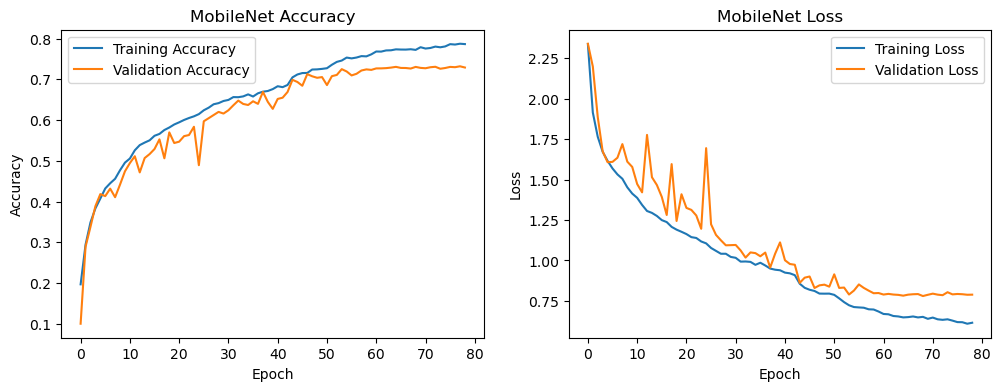

In [9]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load MobileNet without pre-trained weights for CIFAR-10
base_model = MobileNet(weights=None, include_top=False, input_shape=(32, 32, 3))

# Add custom top layers for CIFAR-10 with Batch Normalization and Dropout
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)  # Reduced units to 128
x = BatchNormalization()(x)  # Added Batch Normalization
x = Dropout(0.5)(x)  # Added Dropout
x = Dense(10, activation='softmax')(x)

mobilenet_model = Model(inputs=base_model.input, outputs=x)

# Compile with a slightly higher learning rate
mobilenet_model.compile(optimizer=Adam(learning_rate=1e-3),  # Increased learning rate for faster convergence
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

# Callbacks: EarlyStopping and ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Train the model
history_mobilenet = mobilenet_model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=100,  # Increased epochs to give more training time
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate and plot
test_loss_mobilenet, test_accuracy_mobilenet = mobilenet_model.evaluate(X_test, y_test)
print(f'MobileNet Test Accuracy: {test_accuracy_mobilenet}')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_mobilenet.history['accuracy'], label='Training Accuracy')
plt.plot(history_mobilenet.history['val_accuracy'], label='Validation Accuracy')
plt.title('MobileNet Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_mobilenet.history['loss'], label='Training Loss')
plt.plot(history_mobilenet.history['val_loss'], label='Validation Loss')
plt.title('MobileNet Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
mobilenet_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 16, 16, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 16, 16, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 16, 16, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 16, 16, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 8, 8, 64)       │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 8, 8, 128)      │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 8, 8, 128)      │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 8, 8, 128)      │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 10,041,312 (38.30 MB)

 Trainable params: 3,339,722 (12.74 MB)

 Non-trainable params: 22,144 (86.50 KB)

 Optimizer params: 6,679,446 (25.48 MB)